
## 목차:  
STEP 0. 패키지 & 데이터 로드  
STEP 1. 데이터 전처리  
STEP 2. 모델 설계  
STEP 3. 모델 학습  

# STEP 0. 라이브러리 & 데이터 로드

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 폰트 설정

In [3]:
!apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (10.1 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import logging

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

fontpath = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
fontprop = fm.FontProperties(fname=fontpath, size=12)
plt.rcParams["font.family"] = fontprop.get_name()

print(f"설정된 폰트: {fontprop.get_name()}")

설정된 폰트: NanumBarunGothic


## 사용할 라이브러리

In [5]:
import os
import re
import urllib.request
import zipfile
import sentencepiece as spm
import pandas as pd

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.__version__)

2.8.0+cu126


## 데이터 다운로드

In [6]:
%cd "/content/drive/MyDrive/Colab Notebooks/아이펠/AIFFEL_quest_rs/GoingDeeper/GD04"

/content/drive/MyDrive/Colab Notebooks/아이펠/AIFFEL_quest_rs/GoingDeeper/GD04


In [8]:
dataset_dir = os.path.join(os.path.expanduser("./data"), "spa-eng")
os.makedirs(dataset_dir, exist_ok=True)
zip_path = os.path.join(dataset_dir, "spa-eng.zip")

if not os.path.exists(zip_path):
    print("데이터 다운로드 중...")
    url = "http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
    urllib.request.urlretrieve(url, zip_path)
    print("다운로드 완료!")

data_folder = os.path.join(dataset_dir, "spa-eng")
if not os.path.exists(data_folder):
    print("압축 해제 중...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)
    print("압축 해제 완료!")

path_to_file = os.path.join(data_folder, "spa.txt")

print("데이터셋 디렉토리:", os.listdir(dataset_dir))

데이터 다운로드 중...
다운로드 완료!
압축 해제 중...
압축 해제 완료!
데이터셋 디렉토리: ['spa-eng.zip', 'spa-eng']


# STEP 1. 전처리

In [9]:
# 샘플 확인
df = pd.read_csv(path_to_file, sep = "\t", names = ["eng", "spa"])
print(len(df))
df.head()

118964


,eng,spa
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.


In [10]:
# 중복 확인
print(df.duplicated().sum())

# 결측치 확인
print(df.isna().sum())

0
eng    0
spa    0
dtype: int64


In [11]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    return sentence

print("슝~")

슝~


전처리 과정에서 문장의 시작 문자 <start>, 종료 문자 <end> 를 붙여주게 됩니다. 이 작업은 Encoder에 들어갈 입력 문장의 전처리에는 굳이 필요하지 않지만, Decoder의 입력 문장과 라벨로 사용할 출력 문장에는 꼭 필요하게 됩니다. 이전 렉처 노드에서 살펴보았듯, Decoder는 첫 입력으로 사용할 시작 토큰과 문장생성 종료를 알리는 끝 토큰이 반드시 필요하기 때문입니다.

원활한 학습을 위해 데이터는 상위 3만 개만 사용하도록 하겠습니다.



In [12]:
df = df[:30000]

df["eng"] = df["eng"].apply(preprocess_sentence)
df["spa"] = df["spa"].apply(lambda x: preprocess_sentence(x))

df.head()

,eng,spa
0,go .,ve .
1,go .,vete .
2,go .,vaya .
3,go .,v yase .
4,hi .,hola .


## 토큰화

In [13]:
df["eng"].to_csv("eng_corpus.txt", index=False, header=False, sep="\n", encoding="utf-8")
df["spa"].to_csv("spa_corpus.txt", index=False, header=False, sep="\n", encoding="utf-8")

print("파일 저장 완료: eng_corpus.txt, spa_corpus.txt")

파일 저장 완료: eng_corpus.txt, spa_corpus.txt


In [14]:
vocab_size = 3000
pad_id = 0
bos_id = 1
eos_id = 2
unk_id = 3

spm.SentencePieceTrainer.train(
    input = "eng_corpus.txt",
    model_prefix = "encoder_spm",
    vocab_size = vocab_size,
    pad_id = pad_id,
    bos_id = bos_id,
    eos_id = eos_id,
    unk_id = unk_id
)

spm.SentencePieceTrainer.train(
    input = "spa_corpus.txt",
    model_prefix = "decoder_spm",
    vocab_size = vocab_size,
    pad_id = pad_id,
    bos_id = bos_id,
    eos_id = eos_id,
    unk_id = unk_id
)

In [15]:
encoder_tokenizer = spm.SentencePieceProcessor()
encoder_tokenizer.load("encoder_spm.model")

decoder_tokenizer = spm.SentencePieceProcessor()
decoder_tokenizer.load("decoder_spm.model")

True

SentencePiece는 디코딩 과정에서 START_TOKEN과 END_TOKEN을 자동으로 변환해줍니다.



In [16]:
df

,eng,spa
0,go .,ve .
1,go .,vete .
2,go .,vaya .
3,go .,v yase .
4,hi .,hola .
...,...,...
29995,we ll go after we eat .,iremos despu s de comer .
29996,we ll live like kings .,viviremos como reyes .
29997,we ll lose everything .,lo perderemos todo .
29998,we ll meet right here .,nos encontraremos aqu mismo .


In [17]:
eng_sample = df["eng"][10000]
spa_sample = df["spa"][10000]
print(eng_sample)
print(spa_sample)

do you like fish ?
te gusta el pescado ?


문장을 인코딩한 뒤 START_TOKEN과 END_TOKEN을 붙여주겠습니다.



In [18]:
enc_token = encoder_tokenizer.encode(eng_sample)
enc_token = [encoder_tokenizer.bos_id()] + enc_token + [encoder_tokenizer.eos_id()]
enc_token

[1, 27, 7, 39, 324, 9, 2]

In [19]:
# 위 토큰을 디코딩하면?
enc_decoding = encoder_tokenizer.decode(enc_token)
enc_decoding

'do you like fish ?'

START_TOKEN과 END_TOKEN은 데이터셋을 생성하는 과정에서 추가해주도록 하겠습니다. 일반적으로 Padding 작업은 torch.nn.utils.rnn.pad_sequence와 같은 라이브러리를 사용하지만 여기에서는 과정을 좀 더 풀어서 보여드리도록 하겠습니다.



In [20]:
class TranslationDataset(Dataset):
    def __init__(self, data, encoder_tokenizer, decoder_tokenizer, max_len):
        self.data = data
        self.encoder_tokenizer = encoder_tokenizer
        self.decoder_tokenizer = decoder_tokenizer
        self.max_len = max_len
        self.pad_id = 0
        self.bos_id = 1
        self.eos_id = 2

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src_text = self.data.iloc[idx]['eng']
        trg_text = self.data.iloc[idx]['spa']

        src_ids = self.encoder_tokenizer.encode(src_text)
        trg_ids = self.decoder_tokenizer.encode(trg_text)

        src_ids = src_ids[:self.max_len]

        # Decoder의 입력에는 START_TOKEN과 END_TOKEN을 추가해줍니다. 단, 최대 길이 제한을 적용시킵니다.
        trg_input = [self.bos_id] + trg_ids[:self.max_len - 2] + [self.eos_id]
        trg_label = trg_ids[:self.max_len - 1] + [self.eos_id]

        # 길이가 짧은 경우 PAD_TOKEN을 추가해줍니다.
        src_ids = src_ids + [self.pad_id] * (self.max_len - len(src_ids))
        trg_input = trg_input + [self.pad_id] * (self.max_len - len(trg_input))
        trg_label = trg_label + [self.pad_id] * (self.max_len - len(trg_label))

        return torch.tensor(src_ids), torch.tensor(trg_input), torch.tensor(trg_label)

In [21]:
train_ratio = 0.8  # 전체 길이의 80%
MAX_LEN = 30 # 임의의 값
BATCH_SIZE = 64

train_data = df.sample(frac=train_ratio, random_state=42)  # 80% 훈련 데이터
valid_data = df.drop(train_data.index)

train_data.reset_index(drop=True, inplace=True)
valid_data.reset_index(drop=True, inplace=True)

train_data = TranslationDataset(train_data, encoder_tokenizer, decoder_tokenizer, max_len=MAX_LEN)
validataion_data = TranslationDataset(valid_data, encoder_tokenizer, decoder_tokenizer, max_len=MAX_LEN)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validataion_data, batch_size=BATCH_SIZE, shuffle=False)

In [22]:
for src, trg_input, trg_label in train_loader:
    print(src.shape, trg_input.shape, trg_label.shape)
    break

torch.Size([64, 30]) torch.Size([64, 30]) torch.Size([64, 30])


# STEP 2. 모델 설계
각각 1개의 GRU를 갖는 Encoder-Decoder 구조를 설계할 것이다

In [23]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()

        self.W1 = nn.Linear(hidden_dim, hidden_dim)
        self.W2 = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: (batch_size, hidden_dim)
        # encoder_outputs: (src_len, batch_size, hidden_dim)

        src_len = encoder_outputs.shape[0]

        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)  # (batch_size, src_len, hidden_dim)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # (batch_size, src_len, hidden_dim)

        energy = torch.tanh(self.W1(encoder_outputs) + self.W2(hidden))  # (batch_size, src_len, hidden_dim)
        attention = self.v(energy).squeeze(2)  # (batch_size, src_len)

        return nn.functional.softmax(attention, dim=1)  # (batch_size, src_len)

In [24]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hidden_dim)

    def forward(self, src):
        # src : (src_len, batch_size)
        embedded = self.embedding(src)  # embedded : (src_len, batch_size, emb_dim)
        outputs, hidden = self.rnn(embedded)  # outputs : (src_len, batch_size, hidden_dim)

        return outputs, hidden

In [25]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, attention):
        super(Decoder, self).__init__()

        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        # Decoder RNN에는 embedding만 입력
        self.rnn = nn.GRU(emb_dim, hidden_dim)
        # 출력층에는 hidden state와 attention value가 결합되어 입력
        self.fc_out = nn.Linear(hidden_dim + hidden_dim, output_dim)

    def forward(self, input, hidden, encoder_outputs):
        # input : (batch_size,)
        # hidden : (batch_size, hidden_dim)
        # encoder_outputs : (src_len, batch_size, hidden_dim)
        input = input.unsqueeze(0)  # input : (1, batch_size)
        embedded = self.embedding(input)  # embedded : (1, batch_size, emb_dim)

        # attention distribution을 계산합니다. decoder의 이전 hidden state, s_{t-1}와 encoder의 H가 입력됩니다.
        a = self.attention(hidden[-1], encoder_outputs)  # a : (batch_size, src_len)

        # H에 가중치를 부여해 attention value(Context vector) 계산
        a = a.unsqueeze(1)  # a : (batch_size, 1, src_len)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # encoder_outputs : (batch_size, src_len, hidden_dim)
        context = torch.bmm(a, encoder_outputs)  # context : (batch_size, 1, hidden_dim)
        context = context.permute(1, 0, 2)  # context : (1, batch_size, hidden_dim)

        output, hidden = self.rnn(embedded, hidden)

        # 출력층에서는 현재 hidden state와 context vector를 결합하여 예측값 생성
        output = output.squeeze(0)  # output : (batch_size, hidden_dim)
        context = context.squeeze(0)  # context : (batch_size, hidden_dim)
        prediction = self.fc_out(torch.cat((output, context), dim=1))  # (batch_size, output_dim)

        return prediction, hidden, a.squeeze(1)

In [26]:
class Seq2SeqAttention(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg=None, max_len=30, bos_id = 1, eos_id=2):
        # 학습 모드에서는 trg_len 사용, 추론 모드에서는 max_len까지 동적 생성
        batch_size = src.shape[1]
        trg_vocab_size = self.decoder.fc_out.out_features

        # 조기 종료를 위해 tensor가 아닌 리스트 사용
        outputs = []

        # 시각화를 위해 attention 저장
        attentions = []

        # 인코더를 통해 context 생성
        encoder_outputs, hidden = self.encoder(src)

        if trg is not None:
            for t in range(0, trg.shape[0]):
                input = trg[t]
                output, hidden, attention = self.decoder(input, hidden, encoder_outputs)
                outputs.append(output.unsqueeze(0))
                attentions.append(attention.unsqueeze(0))

        else:
		    # inference에서는 target(정답)이 없기 때문에 sos_token을 생성해줍니다.
            input = torch.full((batch_size,), bos_id, dtype=torch.long, device=self.device)
            finished = torch.zeros(batch_size, dtype=torch.bool, device=self.device)

            for t in range(max_len):
                output, hidden, attention = self.decoder(input, hidden,  encoder_outputs)
                outputs.append(output.unsqueeze(0))
                attentions.append(attention.unsqueeze(0))
                top1 = output.argmax(1)
                input = top1

                # 조기 종료 조건
                finished |= (top1 == eos_id)
                if finished.all():
                    break

        outputs = torch.cat(outputs, dim=0)  # (trg_len, batch_size, output_dim)
        attentions = torch.cat(attentions, dim=0)  # (trg_len, batch_size, src_len)

        return outputs, attentions

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = len(encoder_tokenizer)
output_dim = len(decoder_tokenizer)
emb_dim = 256
hid_dim = 512

In [28]:
encoder = Encoder(input_dim, emb_dim, hid_dim).to(device)
attention = BahdanauAttention(hid_dim).to(device)
decoder = Decoder(output_dim, emb_dim, hid_dim, attention).to(device)
model = Seq2SeqAttention(encoder, decoder, device).to(device)

In [29]:
print(model)

Seq2SeqAttention(
  (encoder): Encoder(
    (embedding): Embedding(3000, 256)
    (rnn): GRU(256, 512)
  )
  (decoder): Decoder(
    (attention): BahdanauAttention(
      (W1): Linear(in_features=512, out_features=512, bias=True)
      (W2): Linear(in_features=512, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(3000, 256)
    (rnn): GRU(256, 512)
    (fc_out): Linear(in_features=1024, out_features=3000, bias=True)
  )
)


# STEP 3. 모델 학습
지금까지는 Optimizer 안에 파라미터를 간편하게 입력했지만, Encoder-Decoder 구조의 경우 모델이 분리되어 파라미터를 각각 정의해줘야 합니다.

## (1) Optimizer & Loss

In [30]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=pad_id)

print("슝~")

슝~


## (2) train_step
학습에 필요한 것을 모두 가져가 Loss를 계산한 후 반환하는 함수  

1. model.train()을 호출하여 모델을 학습 모드로 전환합니다.
2. optimizer.zero_grad()를 통해 이전 배치에서 계산된 기울기를 초기화합니다.
3. Encoder에 소스 문장을 전달해 컨텍스트 벡터인 enc_out 을 생성
4. t=0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의. h_dec = enc_hidden Encoder 처리
5. <start> 문장과 enc_out, Hidden State를 기반으로 다음 단어(t=1)를 예측. predictions
6. 예측된 단어와 정답 간의 Loss를 구한 후, t=1의 정답 단어를 다음 입력으로 사용 (예측 단어 사용X)
7. 반복!


In [31]:
def train_step(model, data_loader, optimizer, criterion, epoch):
    model.train()
    epoch_loss = 0

    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}", leave=True)

    for src, trg_input, trg_label in progress_bar:
        src, trg_input, trg_label = src.to(device), trg_input.to(device), trg_label.to(device)
        optimizer.zero_grad()

        outputs,_ = model(src, trg_input)

        # (trg_len, batch_size, output_dim)을 (batch_size * trg_len, output_dim)으로 변환
        outputs = outputs.view(-1, outputs.shape[-1])
        trg_label = trg_label.view(-1)

        loss = criterion(outputs, trg_label)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()

        epoch_loss += loss.item()

        progress_bar.set_postfix(loss=loss.item())

    return epoch_loss / len(data_loader)

print("슝~")


슝~


## (3) 학습 시작

In [32]:
%%time

EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss = train_step(model, train_loader, optimizer, criterion, epoch)
    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}')

Epoch 1: 100%|██████████| 375/375 [01:12<00:00,  5.15it/s, loss=3.67]


Epoch 1/10, Train Loss: 3.9492


Epoch 2: 100%|██████████| 375/375 [01:11<00:00,  5.22it/s, loss=3.31]


Epoch 2/10, Train Loss: 3.3874


Epoch 3: 100%|██████████| 375/375 [01:11<00:00,  5.23it/s, loss=3.17]


Epoch 3/10, Train Loss: 3.2232


Epoch 4: 100%|██████████| 375/375 [01:11<00:00,  5.21it/s, loss=3.21]


Epoch 4/10, Train Loss: 3.1302


Epoch 5: 100%|██████████| 375/375 [01:11<00:00,  5.21it/s, loss=3.1]


Epoch 5/10, Train Loss: 3.0697


Epoch 6: 100%|██████████| 375/375 [01:11<00:00,  5.24it/s, loss=3.02]


Epoch 6/10, Train Loss: 3.0252


Epoch 7: 100%|██████████| 375/375 [01:11<00:00,  5.22it/s, loss=2.95]


Epoch 7/10, Train Loss: 2.9873


Epoch 8: 100%|██████████| 375/375 [01:11<00:00,  5.24it/s, loss=3.03]


Epoch 8/10, Train Loss: 2.9580


Epoch 9: 100%|██████████| 375/375 [01:11<00:00,  5.22it/s, loss=2.94]


Epoch 9/10, Train Loss: 2.9292


Epoch 10: 100%|██████████| 375/375 [01:11<00:00,  5.22it/s, loss=2.81]

Epoch 10/10, Train Loss: 2.9045
CPU times: user 11min 44s, sys: 4.38 s, total: 11min 48s
Wall time: 11min 59s


In [33]:
def eval_step(model, data_loader, optimizer, criterion):
    model.eval()
    total_loss = 0

    for src, trg_input, trg_label in data_loader:
        src, trg_input, trg_label = src.to(device), trg_input.to(device), trg_label.to(device)

        outputs, _ = model(src, trg_input)

        # (trg_len, batch_size, output_dim)을 (batch_size * trg_len, output_dim)으로 변환
        outputs = outputs.view(-1, outputs.shape[-1])
        trg_label = trg_label.view(-1)

        loss = criterion(outputs, trg_label)

        total_loss += loss.item()

    return total_loss / len(data_loader)

print("슝~")

슝~


In [34]:
%%time

EPOCHS = 20

for epoch in range(EPOCHS):
    train_loss = train_step(model, train_loader, optimizer, criterion, epoch)
    valid_loss = eval_step(model, validation_loader, optimizer, criterion)
    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}')

Epoch 1: 100%|██████████| 375/375 [01:11<00:00,  5.23it/s, loss=2.84]


Epoch 1/20, Train Loss: 2.8852, Validation Loss: 3.3006


Epoch 2: 100%|██████████| 375/375 [01:12<00:00,  5.20it/s, loss=2.8]


Epoch 2/20, Train Loss: 2.8654, Validation Loss: 3.3080


Epoch 3: 100%|██████████| 375/375 [01:12<00:00,  5.21it/s, loss=2.94]


Epoch 3/20, Train Loss: 2.8438, Validation Loss: 3.3237


Epoch 4: 100%|██████████| 375/375 [01:12<00:00,  5.20it/s, loss=2.91]


Epoch 4/20, Train Loss: 2.8211, Validation Loss: 3.3524


Epoch 5: 100%|██████████| 375/375 [01:12<00:00,  5.19it/s, loss=2.92]


Epoch 5/20, Train Loss: 2.8026, Validation Loss: 3.3542


Epoch 6: 100%|██████████| 375/375 [01:11<00:00,  5.23it/s, loss=2.88]


Epoch 6/20, Train Loss: 2.7850, Validation Loss: 3.3746


Epoch 7: 100%|██████████| 375/375 [01:11<00:00,  5.22it/s, loss=2.76]


Epoch 7/20, Train Loss: 2.7649, Validation Loss: 3.3695


Epoch 8: 100%|██████████| 375/375 [01:12<00:00,  5.20it/s, loss=2.79]


Epoch 8/20, Train Loss: 2.7511, Validation Loss: 3.3877


Epoch 9: 100%|██████████| 375/375 [01:11<00:00,  5.21it/s, loss=2.75]


Epoch 9/20, Train Loss: 2.7308, Validation Loss: 3.3765


Epoch 10: 100%|██████████| 375/375 [01:12<00:00,  5.21it/s, loss=2.76]


Epoch 10/20, Train Loss: 2.7180, Validation Loss: 3.3905


Epoch 11: 100%|██████████| 375/375 [01:12<00:00,  5.19it/s, loss=2.82]


Epoch 11/20, Train Loss: 2.6974, Validation Loss: 3.4101


Epoch 12: 100%|██████████| 375/375 [01:11<00:00,  5.22it/s, loss=2.66]


Epoch 12/20, Train Loss: 2.6843, Validation Loss: 3.4189


Epoch 13: 100%|██████████| 375/375 [01:11<00:00,  5.23it/s, loss=2.78]


Epoch 13/20, Train Loss: 2.6675, Validation Loss: 3.4014


Epoch 14: 100%|██████████| 375/375 [01:11<00:00,  5.21it/s, loss=2.92]


Epoch 14/20, Train Loss: 2.6515, Validation Loss: 3.4437


Epoch 15: 100%|██████████| 375/375 [01:12<00:00,  5.20it/s, loss=2.78]


Epoch 15/20, Train Loss: 2.6325, Validation Loss: 3.4260


Epoch 16: 100%|██████████| 375/375 [01:12<00:00,  5.21it/s, loss=2.67]


Epoch 16/20, Train Loss: 2.6241, Validation Loss: 3.4487


Epoch 17: 100%|██████████| 375/375 [01:12<00:00,  5.20it/s, loss=2.58]


Epoch 17/20, Train Loss: 2.6080, Validation Loss: 3.4395


Epoch 18: 100%|██████████| 375/375 [01:12<00:00,  5.19it/s, loss=2.66]


Epoch 18/20, Train Loss: 2.5974, Validation Loss: 3.4713


Epoch 19: 100%|██████████| 375/375 [01:12<00:00,  5.20it/s, loss=2.69]


Epoch 19/20, Train Loss: 2.5844, Validation Loss: 3.4427


Epoch 20: 100%|██████████| 375/375 [01:12<00:00,  5.20it/s, loss=2.73]


Epoch 20/20, Train Loss: 2.5706, Validation Loss: 3.4600
CPU times: user 25min 36s, sys: 9.7 s, total: 25min 46s
Wall time: 26min 6s


In [35]:
def evaluate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len=30):
    model.eval()

    sentence = preprocess_sentence(sentence)
    src_ids = encoder_tokenizer.encode(sentence)
    src_ids = src_ids[:max_len]
    src_ids = src_ids + [0] * (max_len - len(src_ids))  # 패딩 추가
    src_tensor = torch.tensor(src_ids).unsqueeze(1).to(device)  # (src_len, 1)

    with torch.no_grad():
        outputs, attentions = model(src_tensor, max_len=max_len)

    result = [decoder_tokenizer.decode([token.item()]) for token in outputs.argmax(2).squeeze(1)]

    if "<end>" in result:
        result = result[:result.index("<end>")]

    return result, sentence, attentions.squeeze(1).cpu().numpy()

In [36]:
def plot_attention(attention, sentence, predicted_sentence):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticks(range(len(sentence)))
    ax.set_xticklabels(sentence, fontdict=fontdict, rotation=90)

    ax.set_yticks(range(len(predicted_sentence)))
    ax.set_yticklabels(predicted_sentence, fontdict=fontdict)

    plt.show()

In [37]:
def translate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len=30):
    result, sentence, attention = evaluate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    # Attention 크기 조정 (trg_len, src_len)
    attention = attention[:len(result), :len(sentence.split())]

    plot_attention(attention, sentence.split(), result)

Input: the most powerful man all over the world .
Predicted translation: ['el', 'd', 'inero', '.', '']


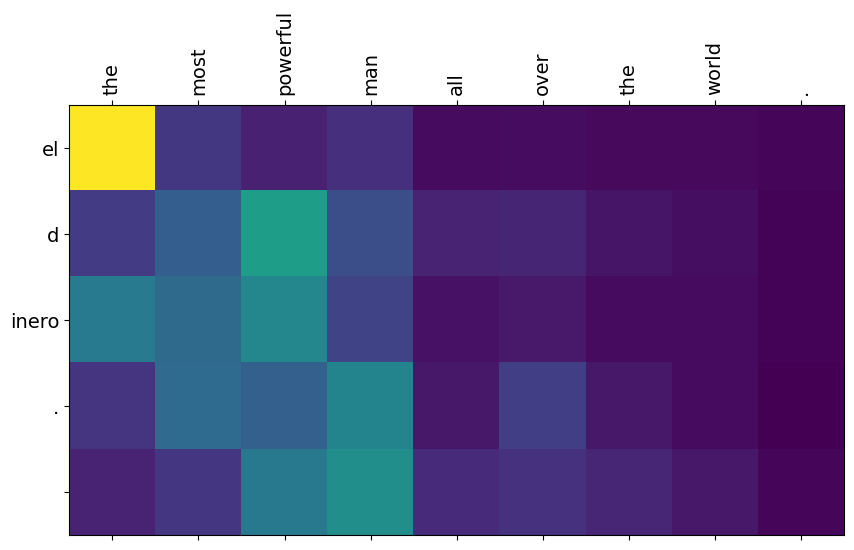

In [38]:
translate("The most powerful man all over the world.", model, encoder_tokenizer, decoder_tokenizer, max_len=30)

Input: may i help you ?
Predicted translation: ['tal', '', 'eres', 'ayudar', '.', '']


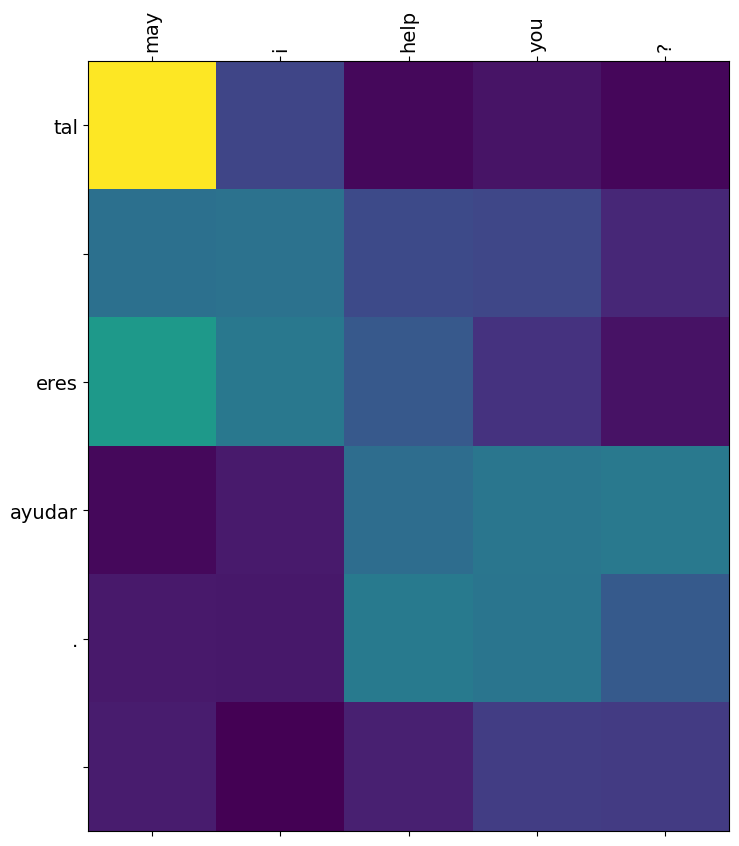

In [39]:
translate("May I help you?", model, encoder_tokenizer, decoder_tokenizer, max_len=30)

Input: can i have some coffee ?
Predicted translation: ['.', '']


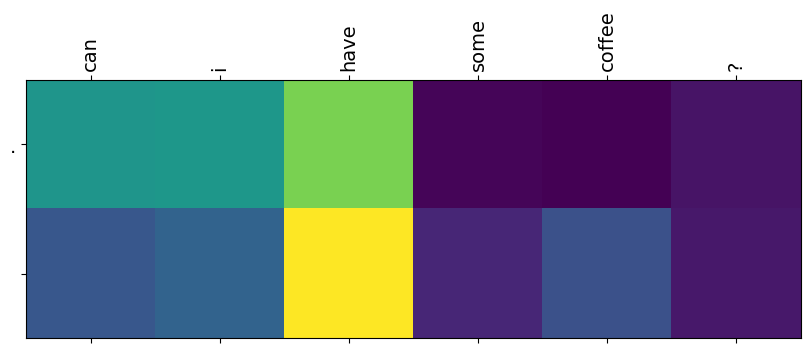

In [40]:
# 실행 예제
translate("Can I have some coffee?", model, encoder_tokenizer, decoder_tokenizer, max_len=30)